# Fitting to variety mixture data
Uses data from: *Control of Septoria tritici blotch by winter wheat cultivar mixtures: Meta-analysis of 19 years of cultivar trials, Kristoffersen et al., 2020*

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# For simulation
from Functions_base import ic_twofield, t_growing, T69, T75

# For ODEs
from Functions_base import beta_base, Temerge, gamma, g_1D, sigma, mu, v
# For plotting
from Functions_base import G, Temerge, T87, T61
from Functions_plotting import plot_one_intervention

In [2]:
# Disease system. _M is IPM and _N is no control
def dPop(ic,t,epi_severity,r_beta):
    
    beta = beta_base*epi_severity
    
    S_M,E_M,I_M,R_M,D_M,P_M = ic[:6]
    S_N,E_N,I_N,R_N,D_N,P_N = ic[6:]
    
    A_M = S_M + E_M + I_M + R_M + D_M
    A_N = S_N + E_N + I_N + R_N + D_N
    
    # Variety mixture fields
    if t > Temerge:
        FOL = gamma*E_M
            
        # Set variety dependant transmission rate
        FOI = (r_beta**2)*beta*(I_M + P_M)

        dS_M = g_1D(A_M,t) - sigma(t)*S_M - (S_M/A_M)*FOI
        dE_M = (S_M/A_M)*FOI - sigma(t)*E_M - FOL
        dI_M = FOL - mu*I_M
        dR_M = sigma(t)*(S_M+E_M)
        dD_M = mu*I_M
        dP_M = -v*P_M
        
    else:
        dS_M = 0
        dE_M = 0
        dI_M = 0
        dR_M = 0
        dD_M = 0
        dP_M = 0

    # Uncontrolled fields
    if t > Temerge:
        
        # Set uncontrolled FOI
        FOI = beta*(I_N + P_N)
        
        dS_N = g_1D(A_N,t) - sigma(t)*S_N - (S_N/A_N)*FOI
        dE_N = (S_N/A_N)*FOI - sigma(t)*E_N - gamma*E_N
        dI_N = gamma*E_N - mu*I_N
        dR_N = sigma(t)*(S_N+E_N)
        dD_N = mu*I_N
        dP_N = -v*P_N
        
    else:
        dS_N = 0
        dE_N = 0
        dI_N = 0
        dR_N = 0
        dD_N = 0
        dP_N = 0

    return [dS_M,dE_M,dI_M,dR_M,dD_M,dP_M, dS_N,dE_N,dI_N,dR_N,dD_N,dP_N]

In [3]:
# Set time parameters
idx_6975 = slice(T69-Temerge, T75-Temerge,1)
t_6975 = t_growing[idx_6975]

In [4]:
# Run through values of r_beta, and print the percentage of infection reduction seen

severity = 1

for i in np.arange(0.95,1,0.0005):
    
    # Set the scaling value for beta for variety mixtures
    r_beta = i
    pop = odeint(func = dPop, y0 = ic_twofield, t = t_growing, args = (severity,r_beta))
    
    # Clip at assessment period
    pop = pop[idx_6975,:]
    
    # Get IPM values
    pop_ipm = pop[:,:5]
    tot_ipm = np.sum(pop_ipm, axis = 1)
    I_ipm = pop_ipm[:,2]
    
    # Get no control values
    pop_nocontrol = pop[:,6:-1]
    tot_nocontrol = np.sum(pop_nocontrol, axis = 1)
    I_nocontrol = pop_nocontrol[:,2]
    
    # Compute the proportion infection by integrating over the time period
    prop_ipm = np.trapz(t_6975,I_ipm/tot_ipm)
    prop_nocontrol = np.trapz(t_6975,I_nocontrol/tot_nocontrol)
    
    # print values - targets are 16.3, 9.0 and 1
    print("Reduction of " + str(round(100 - 100*prop_ipm/prop_nocontrol,4)) + "%" , "r beta " + str(round(i,4)))
    print("")

Reduction of 27.5928% r beta 0.95

Reduction of 27.3526% r beta 0.9505

Reduction of 27.1118% r beta 0.951

Reduction of 26.8703% r beta 0.9515

Reduction of 26.6281% r beta 0.952

Reduction of 26.3853% r beta 0.9525

Reduction of 26.1417% r beta 0.953

Reduction of 25.8975% r beta 0.9535

Reduction of 25.6526% r beta 0.954

Reduction of 25.407% r beta 0.9545

Reduction of 25.1607% r beta 0.955

Reduction of 24.9137% r beta 0.9555

Reduction of 24.666% r beta 0.956

Reduction of 24.4177% r beta 0.9565

Reduction of 24.1686% r beta 0.957

Reduction of 23.9188% r beta 0.9575

Reduction of 23.6684% r beta 0.958

Reduction of 23.4172% r beta 0.9585

Reduction of 23.1654% r beta 0.959

Reduction of 22.9128% r beta 0.9595

Reduction of 22.6595% r beta 0.96

Reduction of 22.4056% r beta 0.9605

Reduction of 22.1509% r beta 0.961

Reduction of 21.8955% r beta 0.9615

Reduction of 21.6394% r beta 0.962

Reduction of 21.3826% r beta 0.9625

Reduction of 21.1251% r beta 0.963

Reduction of 20.866

## Parameters found
Search the above for the closest values of r_beta to the data from Kristoffersen et al. 2020

| Percent reduction | r_beta |
|-|-|
| 16.3% | 0.972 |
| 9.00% | 0.985 |
| 1.00% | 0.998 |

In [5]:
# Run with the final values for plotting
# Highest reduction
pop1 = odeint(func = dPop, y0 = ic_twofield, t = t_growing, args = (severity,0.972))
pop_nocontrol = pop1[:,6:-1]

# Medium reduction
pop2 = odeint(func = dPop, y0 = ic_twofield, t = t_growing, args = (severity,0.985))

# Lowest reduction
pop3 = odeint(func = dPop, y0 = ic_twofield, t = t_growing, args = (severity,0.998))

Yields
[0.9014147425781315, 0.9082814625093604, 0.914806855143612]
Peak percent infection
[0.13832141091842642, 0.1290487509517977, 0.12001468207032237]


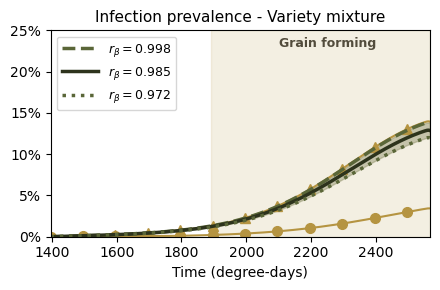

In [6]:
# Run imported plotting function
fig,ax = plot_one_intervention([pop1[:,:6],pop2[:,:6],pop3[:,:6]][::-1],[r"$r_\beta = 0.972$", r"$r_\beta = 0.985$", r"$r_\beta = 0.998$"][::-1],"Variety mixture")
plt.tight_layout()
# Save figure
fig.savefig('Figures/Manuscript_final/fig_1control_varietymix.pdf', dpi=400)